# Run Q3Dfit from this Jupyter Notebook in Astroconda Environment.

This Jupyter notebook allows you to run Q3Dfit, a PSF decomposition and spectral analysis package tailored for JWST NIRSpec and MIRI IFU observations. 

Q3Dfit is developed as a science-enabling data product by the Early Release Science Team #1335 Q3D. You can find more information about this ERS program **Q3D** [here](https://wwwstaff.ari.uni-heidelberg.de/dwylezalek/q3d.html) and [here](https://www.stsci.edu/jwst/science-execution/approved-programs/dd-ers/program-1335).

The software is based on the existing package IFSFIT developed by Dave Rupke (see [ADS link](https://ui.adsabs.harvard.edu/abs/2017ApJ...850...40R/abstract)).

The following notebook will guide you through the initialization procedure and will then perform the analysis. 

## Table of Contents

* [1. Initialization](#chapter1)
    * [1.1. Setting up the directory tree](#chapter1_1)
    * [1.2. Setting up the fitting parameters](#chapter1_2)        
* [2. Run Q3Dfit](#chapter2)
* [3. Run plotting script (q3da)](#chapter3)



<font color='red'>We need to decide where the makeqsotemplate functionality goes. </font>

## 1. Initialization <a class="anchor" id="chapter1"></a>

In [1]:
import os.path
import numpy as np

### 1.1. Setting up the directory tree <a class="anchor" id="chapter1_1"></a>

Define the directories in which your data cube(s) that you want to analyse are stored and the output directories. We recommend creating a working directory that you name after your target, in which all outputs from Q3Dfit will be saved. 

In [2]:
volume = '/Users/dwylezal/EmmyNoether_Science/Q3D/JWST_ERS_Planning/Software/PG1411/'
gal = 'pg1411' # name of your main working directory
outstr = 'rb3'
infile = volume+gal+outstr+'.fits' # path + name of your input cube
mapdir = volume+gal+'/'+outstr+'/' # directory for saving the output maps
outdir = volume+gal+'/'+outstr+'/' # directory for saving the output files

qsotemplate = volume+gal+'qsotemplate.npy' 
stellartemplates =  \
    volume+gal+'hosttemplate.npy'
logfile = outdir+gal+'_fitlog.txt'

# DW: do we need these???
batchfile = '/Users/dwylezal/ESO_Fellowship/JWST_ERS_Planning/Software/ifsfit-master/common/fitloop.pro'
batchdir = '/Users/dwylezal/ESO_Fellowship/JWST_ERS_Planning/Software/'   

Some general information about your cube:

In [3]:
ncols = 17 # number of columns
nrows = 26 # number of rows
# centcol = 9.002
# centrow = 14.002
platescale = 0.3
fitrange = [4620,7450] #in Angstrom

if not os.path.isfile(infile): print('Data cube not found.')

### 1.2. Setting up the fitting parameters <a class="anchor" id="chapter1_2"></a>

What lines do you want to fit? You can choose from the linelist <font color='red'>provide reference here</font>.

In [4]:
lines = ['Halpha','Hbeta', '[OI]6300','[OI]6364','[OIII]4959','[OIII]5007', '[NII]6548','[NII]6583','[SII]6716','[SII]6731']

How many components do you want to be fitted to the emission lines?

In [5]:
maxncomp = 1

In [6]:
# Initialize line ties, n_comps, z_inits, and sig_inits.
linetie = dict()
ncomp = dict()
zinit_gas = dict()
siginit_gas = dict()
for i in lines:
    linetie[i] = 'Halpha'
    ncomp[i] = np.full((ncols,nrows),maxncomp)
    ncomp[i][8,13] = 0
    zinit_gas[i] = np.full((ncols,nrows,maxncomp),0.0898)
    siginit_gas[i] = np.full(maxncomp,50)
    zinit_gas[i][2,18,:]=0.091
    zinit_gas[i][4,21:22,:]=0.091
    zinit_gas[i][5,21,:]=0.091
    zinit_gas[i][6:8,23:25,:]=0.091
    zinit_gas[i][1:4,1:7,:]=0.0894
    zinit_gas[i][6:16,0:7,:]=0.089
    zinit_gas[i][11,8:9,:]=0.089
    zinit_stars=np.full((ncols,nrows),0.0898)

#
# Optional pars
#

# Tweaked regions are around HeII,Hb/[OIII],HeI5876/NaD,[OI],Halpha, and [SII]
# Lower and upper wavelength for re-fit
tw_lo = [4600,5200,6300,6800,7000,7275]
tw_hi = [4800,5500,6500,7000,7275,7375]
# Number of wavelength regions to re-fit
tw_n = len(tw_lo)
# Fitting orders
deford = 1
tw_ord = np.full(tw_n,deford)
# Parameters for continuum fit
# In third dimension:
#   first element is lower wavelength limit
#   second element is upper
#   third is fit order
tweakcntfit = np.full((ncols,nrows,3,tw_n),0)
tweakcntfit[:,:,0,:] = tw_lo
tweakcntfit[:,:,1,:] = tw_hi
tweakcntfit[:,:,2,:] = tw_ord

# Parameters for emission line plotting
linoth = np.full((2, 6), '', dtype=object)
linoth[0, 2] = '[OIII]4959'
linoth[0, 3] = '[OI]6364'
linoth[:, 4] = ['[NII]6548', '[NII]6583']
linoth[0, 5] = '[SII]6716'
argspltlin1 = {'nx': 3,
               'ny': 2,
               'label': ['', 'Hbeta', '[OIII]5007',
                         '[OI]6300', 'Halpha', '[SII]6731'],
               'wave': [0,4861,5007,6300,6563,6731],
               'off': [[-120,90],[-80,50],[-130,50],
                     [-80,120],[-95,70],[-95,50]],
               'linoth': linoth}

# Velocity dispersion limits and fixed values
siglim_gas = np.ndarray(2)
siglim_gas[:] = [5, 500]
# lratfix = {'[NI]5200/5198': [1.5]}

#
# Output structure
#

The following cell will create the initialisation structure. **Do not change anything in this cell.** 

In [7]:
initproc = { \
        # Required pars
        'fcninitpar': 'gmos',
        'fitran': fitrange,
        'fluxunits': 1e-15,  # erg/s/cm^2/arcsec^2
        'infile': infile,
        'label': gal,
        'lines': lines,
        'linetie': linetie,
        'maxncomp': maxncomp,
        'name': 'PG1411+442',
        'ncomp': ncomp,
        'mapdir': mapdir,
        'outdir': outdir,
        'platescale': platescale,
        'positionangle': 335,
        'minoraxispa': 75,
        'zinit_stars': zinit_stars,
        'zinit_gas': zinit_gas,
        'zsys_gas': 0.0898,
        # Optional pars
        'argscheckcomp': {'sigcut': 3,
                          'ignore': ['[OI]6300', '[OI]6364',
                                     '[SII]6716', '[SII]6731']},
        'argscontfit': {'blrpar': [0, 7150, 5000/299792*7150,
                                   0, 5300, 5000/299792*5300],
                        'qsoxdr': qsotemplate,
                        'siginit_stars': 50,
                        'uselog': 1,
                        'refit': 1},
        'argslinelist': {'vacuum': False},
        'startempfile': stellartemplates,
        'argspltlin1': argspltlin1,
        # 'donad': 1,
        'decompose_qso_fit': 1,
        # 'remove_scattered': 1,
        'fcncheckcomp': 'checkcomp',
        'fcncontfit': 'fitqsohost',
        'maskwidths_def': 500,
        'tweakcntfit': tweakcntfit,
        'emlsigcut': 2,
        'logfile': logfile,
        'batchfile': batchfile,
        'batchdir': batchdir,
        'siglim_gas': siglim_gas,
        'siginit_gas': siginit_gas,
        'siginit_stars': 50,
        'cutrange': np.array([6410, 6430]),
        'nocvdf': 1,
        # 'cvdf_vlimits': [-3e3,3e3],
        # 'cvdf_vstep': 10d,
        # 'host': {'dat_fits': volume+'ifs/gmos/cubes/'+gal+'/'+\
        #         gal+outstr+'_host_dat_2.fits'} \
    }

If you want to run q3dfit in batch mode, run this cell, which saves initproc to an "npy" file. In your python command line, read in that "npy" file with <pre><code> initproc = np.load('path/to/the/npy/file/initproc.npy') </code></pre> and then run q3dfit with <pre><code> q3df(initproc,cols=cols,rows=rows) </code></pre>

In [8]:
path_to_npy_file = '/Users/dwylezal/EmmyNoether_Science/Q3D/JWST_ERS_Planning/Software/PG1411/'
initproc_npy = 'initproc.npy'
np.save(path_to_npy_file+initproc_npy,initproc)

## 2. Run Q3Dfit <a class="anchor" id="chapter2"></a>

In [9]:
# This may be unique to the user, insert your path to the q3dfit/ folder here
import sys
if '../../' not in sys.path:
    sys.path.append('../../')

from q3dfit.common.q3df import q3df
from q3dfit.common.q3da import q3da

In [11]:
cols = [14]
rows = [11]

In [12]:
q3df(initproc,cols=cols,rows=rows)

## 3. Run plotting script (q3da) <a class="anchor" id="chapter3"></a>

CUBE: Negative values encountered in variance array.


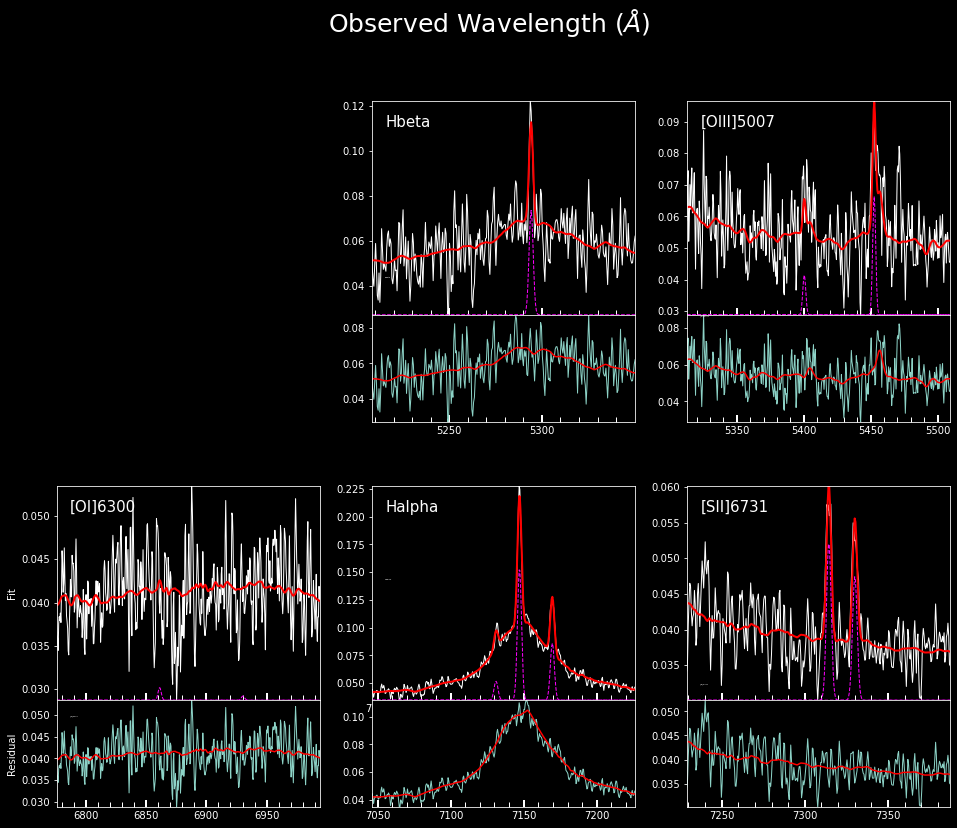

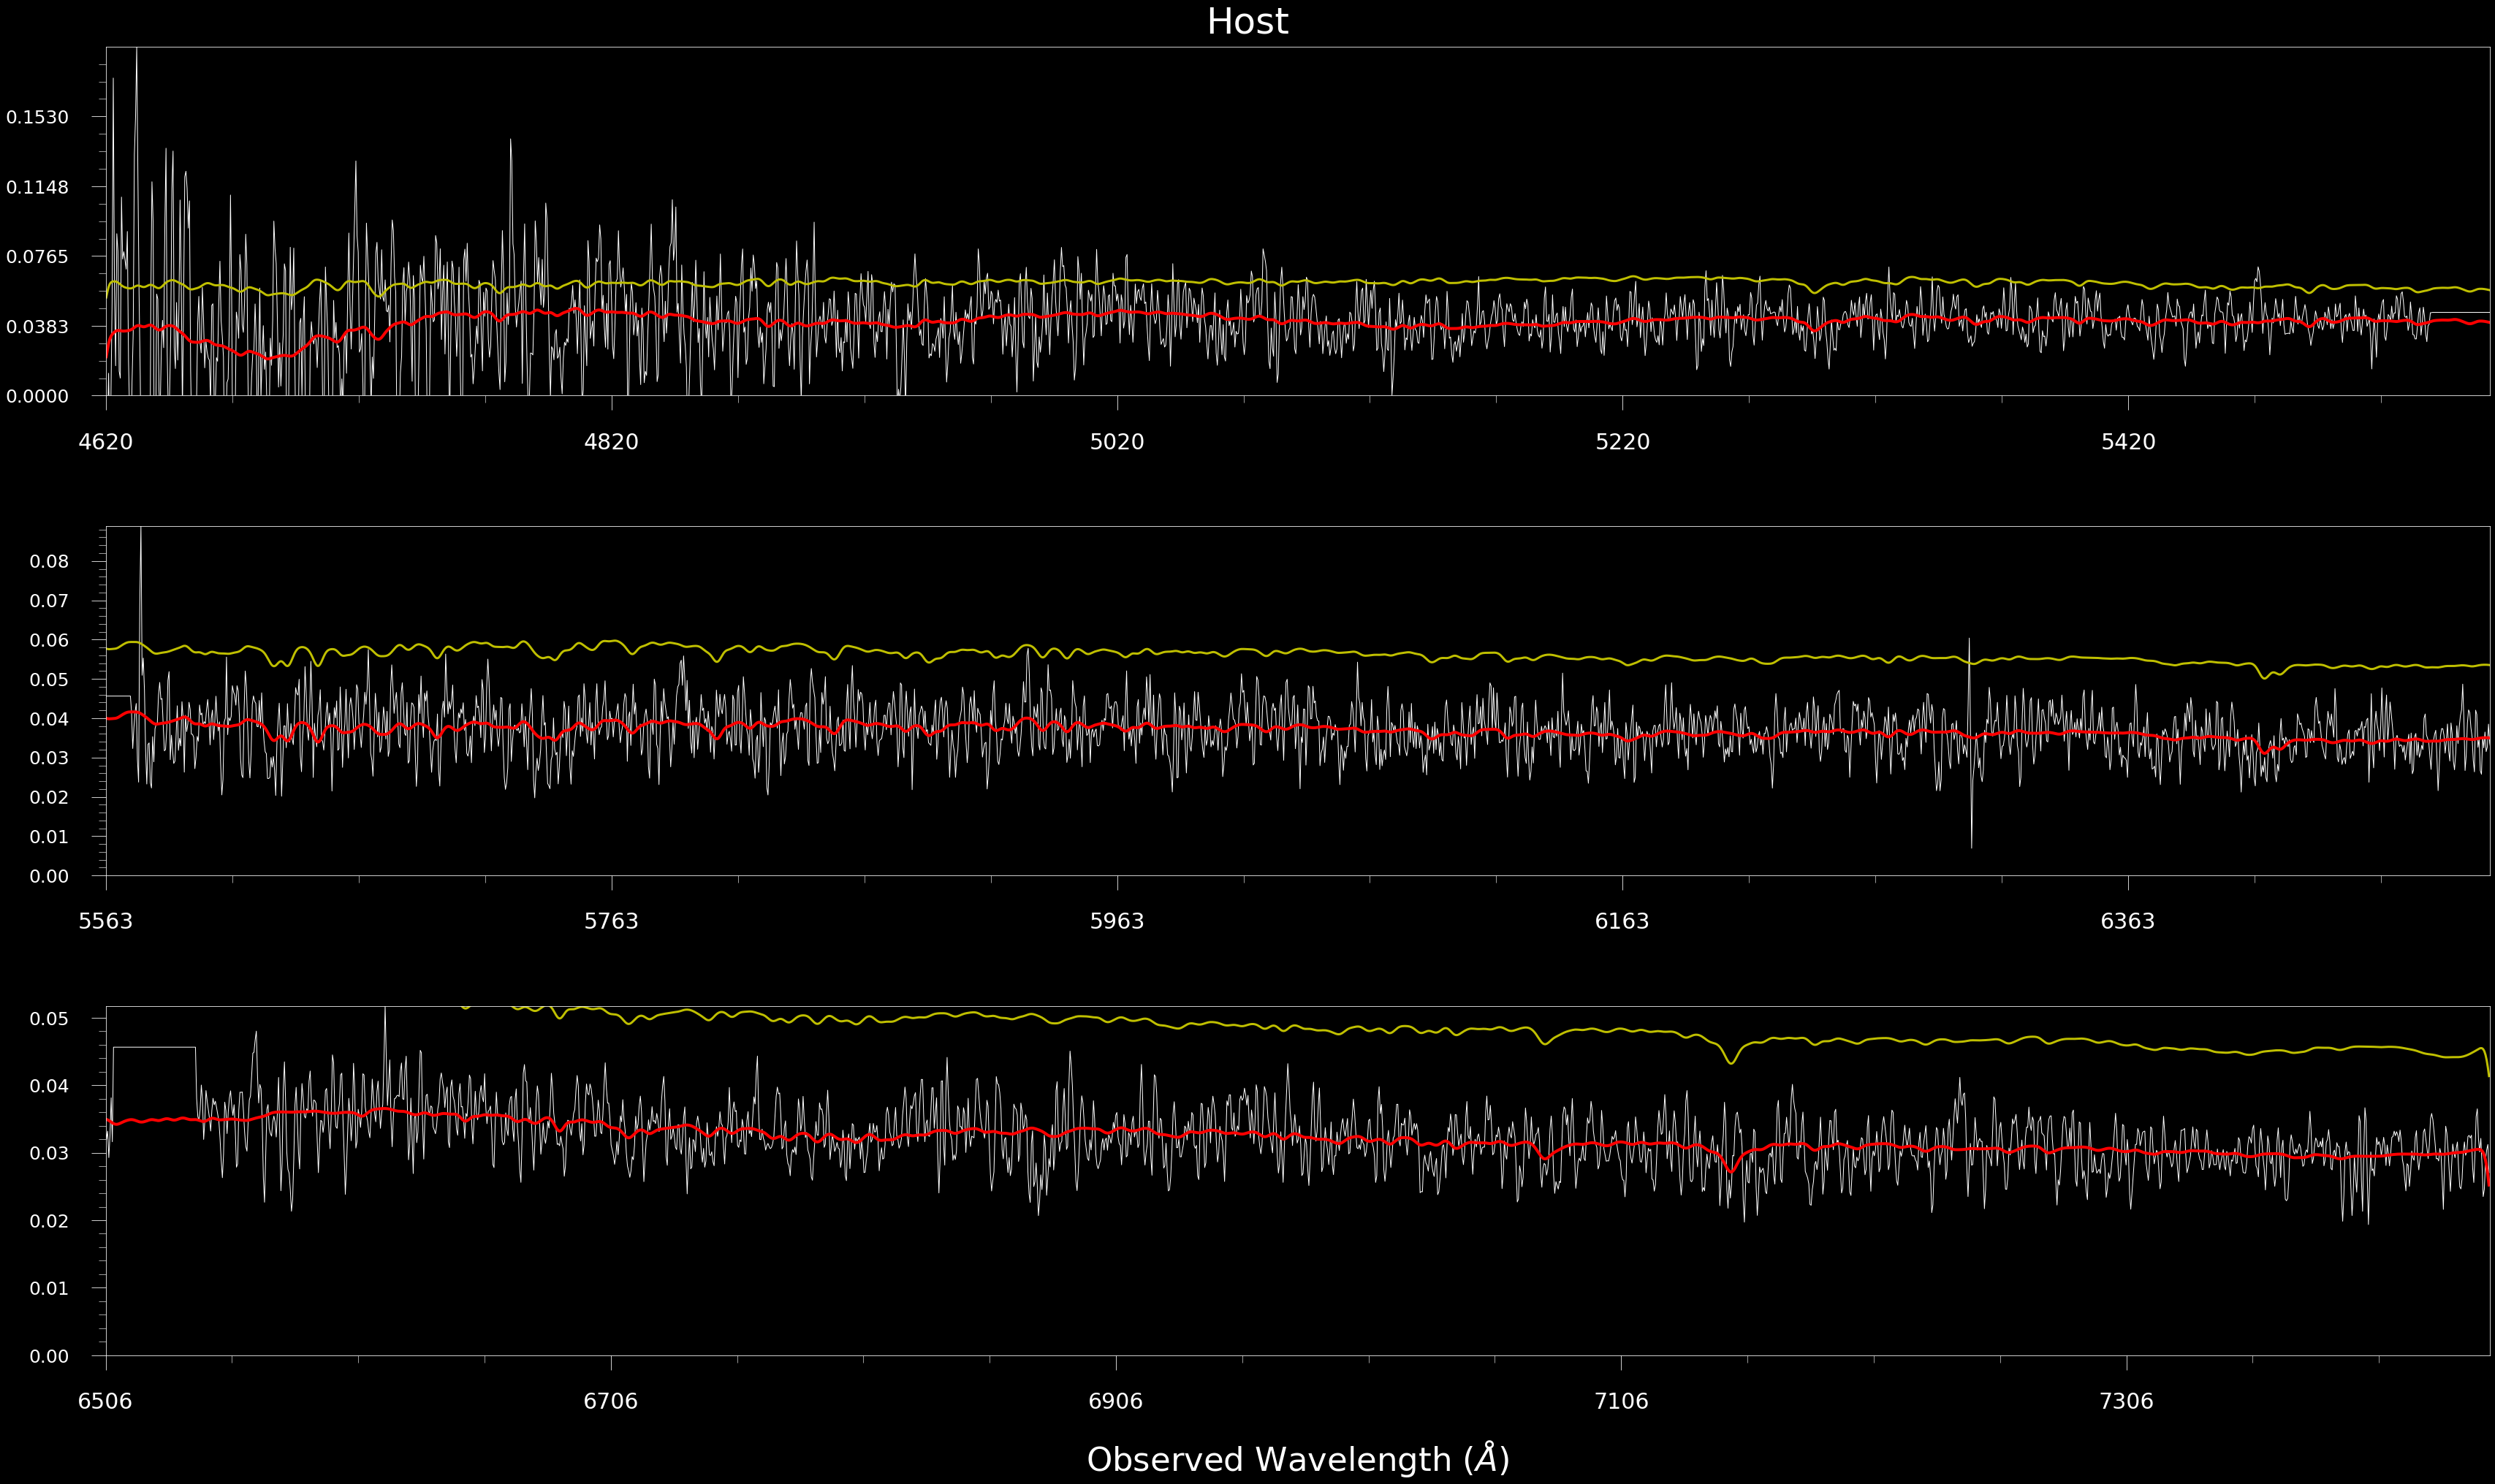

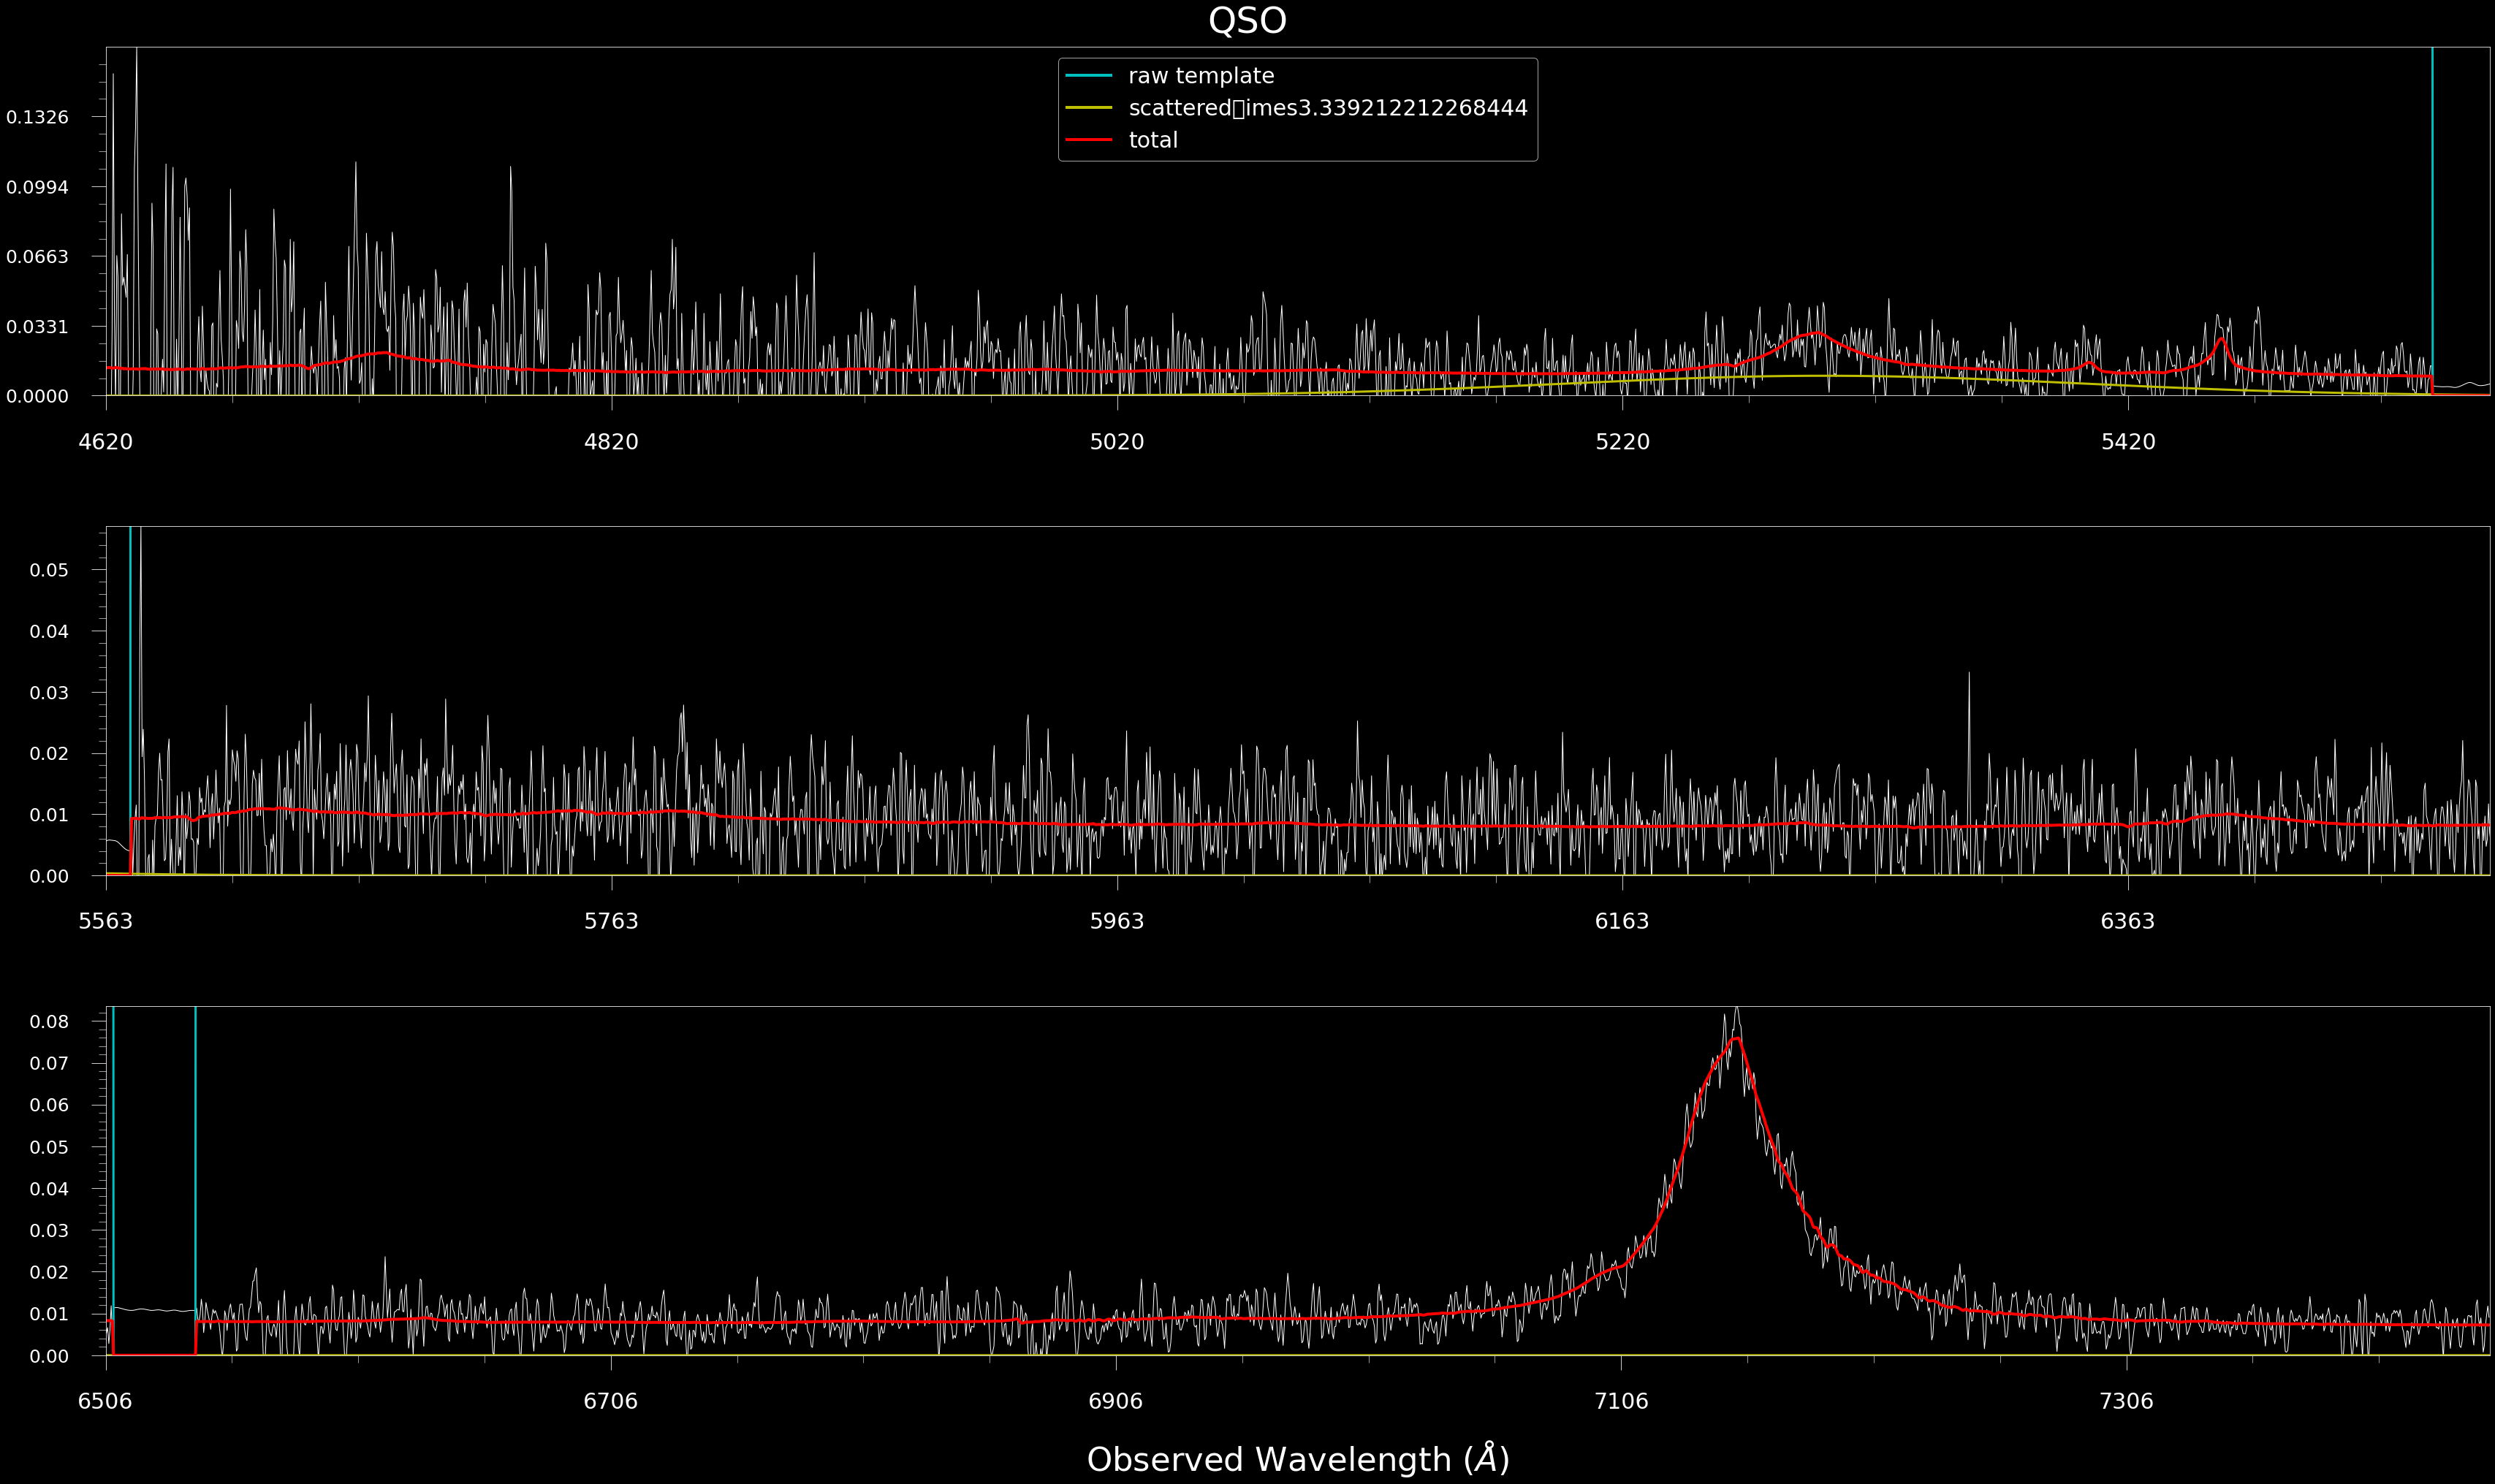

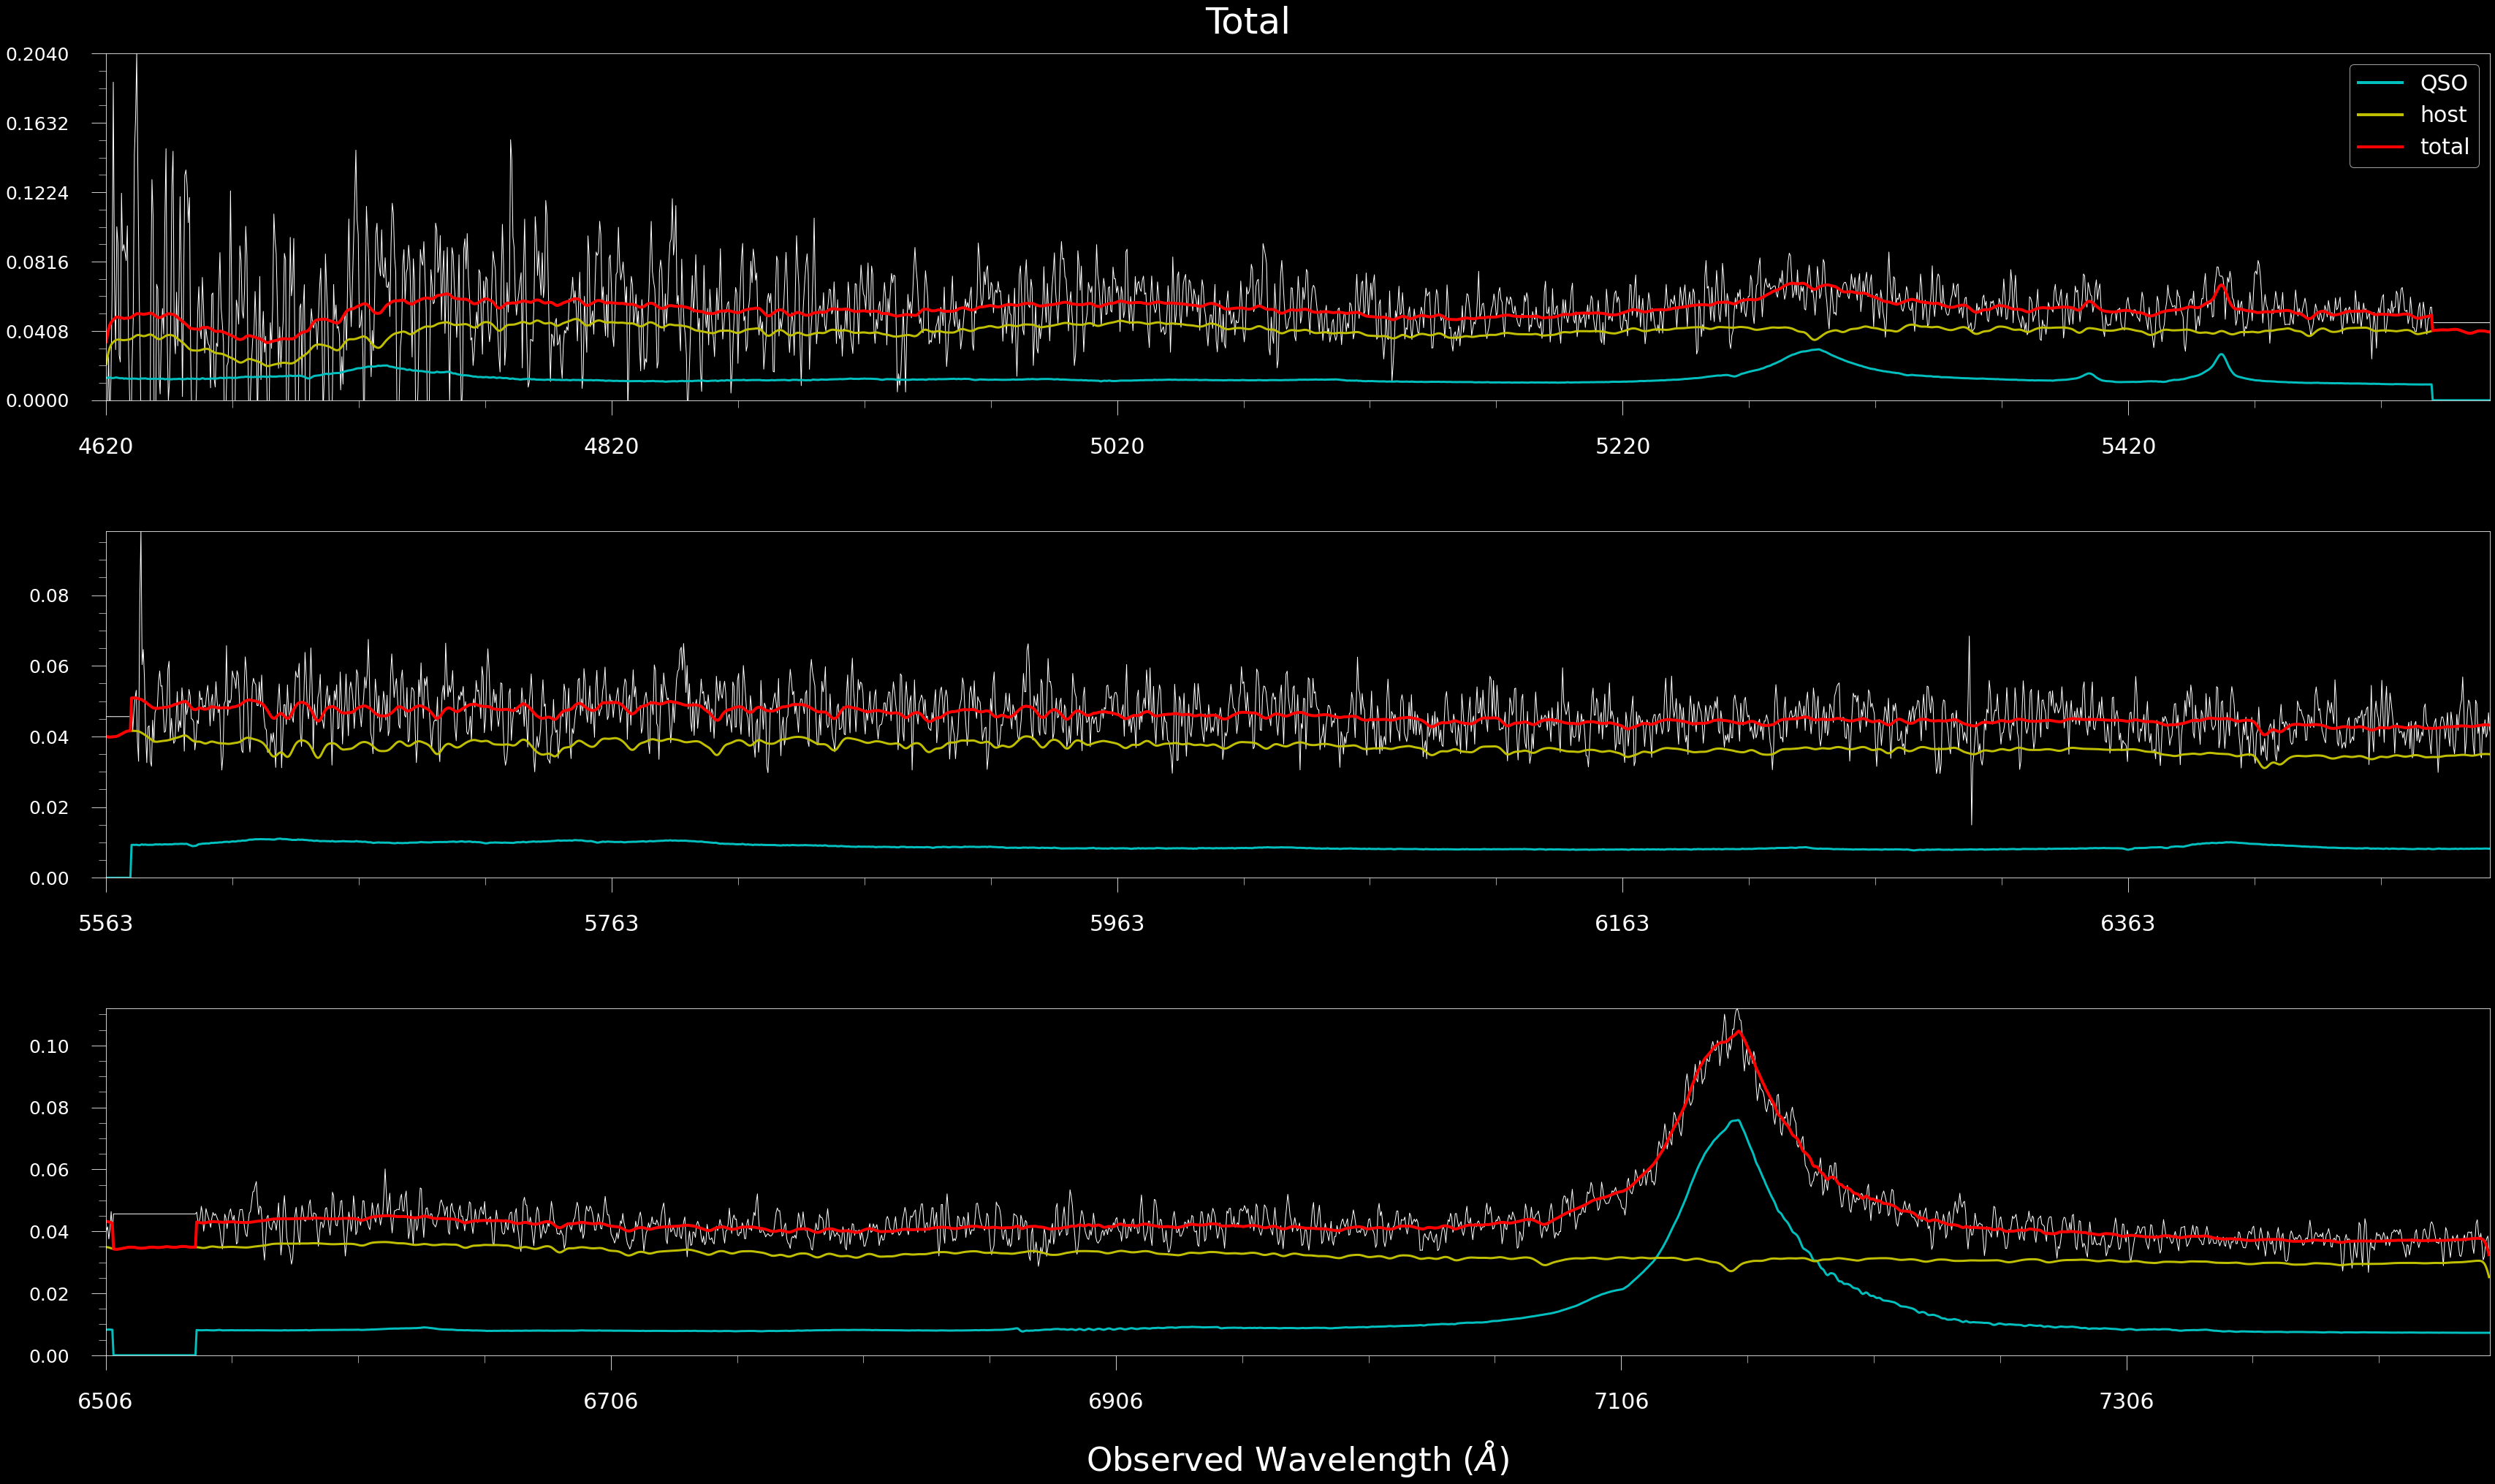

In [13]:
q3da(initproc,cols=cols,rows=rows)